# Time and Frequency in EEG 



In [1]:
import numpy as np
from matplotlib import pyplot as plt 
##THIS IS NEW
from scipy.fftpack import fft, ifft  #THIS IS THE NEW FUNCTION!
from hdf5storage import loadmat 

In [2]:
def sinusoid(f,t,A = 1,theta = 0):
    ''' makes a sinusoid of given frequency (f) at the time points given in t. 
    Amplitude (A) and phase (theta) can be optionally specified.  Phase is given in degrees not radians'''
    theta = theta*np.pi/180 #convert theta from degrees to radians
    e = A*np.cos(2*np.pi*f*t+theta)
    return e

## Frequency Resolution and Units

### In this section we will revisit the notion of frequency resolution, and take that into consideration in designing the units with which we evaluate amplitdue. 



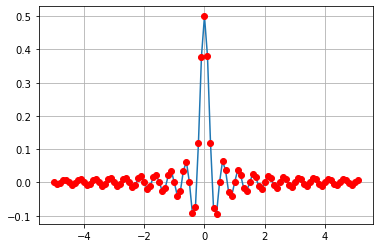

In [3]:
samplingrate = 200 # this is the rate at which the signal is sampled.  
ts = 1/samplingrate #  this is the interval in time between samples.  
T = 2 #This is the total length (in seconds) of the interval. 
t = np.arange(0,T,ts) #this is the time time vector with 1 value of time for each sample.  
#manipulate phase (theta) 
es = dict()
f1 = 20
f = np.arange(15,25.1,0.1)
fplot = f-f1;
nof = np.size(f)
nsamp = np.size(t)
dp = np.zeros(nof)
for j in range(nof):
    es[0] = sinusoid(f[j],t)
    es[1] = sinusoid(f1,t)
    dp[j] = np.sum(es[0]*es[1])/nsamp 
plt.plot(fplot,dp)
plt.plot(fplot,dp,'ro')
plt.grid()
plt.show()


### Discretization of Frequency 

#### When we sample the time series, we discretize time by the sampling rate.  In the example above `ts = 1/samplingrate` is 0.05 s. 
#### Whatever value we have at each time step (`t`) is actually a value fixed for an interval time **centered** on that value of `t`

#### Similarly, frequency is discrate. The frequency resolved by the FFT depends on the interval `T` as 

#### $$ f_n = n/T $$ where n is any integer upto the number of samples divided by 2 (Nyquist theorem).  

#### so if `T` = 2s, $f_n = n/T = n/2 = 0,0.5,1,1.5,2...... $

* ####  f = 0.5 is the **interval** [0.25,0.75]
* ####  f = 1 is the **interval** [0.75, 1.25]

####  if `T` = 0.5s, $f_n = n/T = n/0.5 =  0,2,4,6,8....... $

* ####  f = 2 is the **interval** [1,3]
* ####  f = 4 is the **interval** [3, 5]

dict_keys(['__header__', '__version__', '__globals__', 'lfp', 'fs', 'spike_indices', 'spike_fs'])


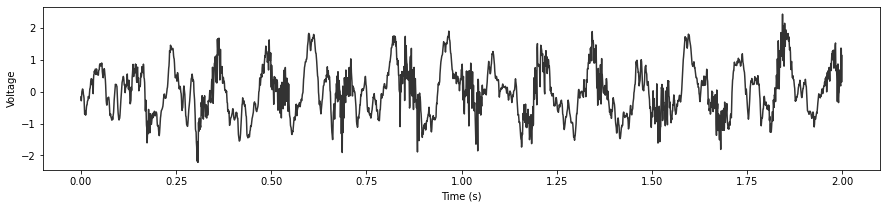

In [4]:
data = loadmat('data/LFP.mat', squeeze_me=True)
print(data.keys())

# unpack the variables
fs = data['fs'] # sampling rate 
deltaT = 1/fs # time steps
T = 2# segment length 
nsamp = int(T*fs) # number of samples is the segment length

lfp = data['lfp'][0,:]/1000 
lfp_short = lfp[range(0,nsamp)] # make a variable that has only the first T seconds of the LFP
t_short = np.arange(0, nsamp*deltaT, deltaT) # create the corresponding time vector
plt.figure(figsize=(15,3))
plt.plot(t_short,lfp_short, 'k', alpha=0.8)
plt.xlabel('Time (s)');
plt.ylabel('Voltage');
plt.show()

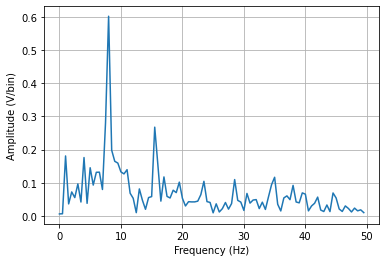

In [5]:
#FFT the whole thing.  
xf = fft(lfp_short) #take the fft 
deltaF = 1/T 
amplitude = 2*np.abs(xf)/nsamp
nf = int(np.floor(nsamp/2)) #number of frequencies you can estimate is 1/2 the number of samples.
                            #I used floor just in case nsamp is odd. 
f_n = np.arange(0,nf)*deltaF
maxf = 50  #highest frequency I want to plot
maxbin = int(maxf/deltaF) #index corresponding to highest frequency to plot.  
plt.plot(f_n[0:maxbin],amplitude[0:maxbin])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V/bin)')
plt.grid(True)
plt.show()


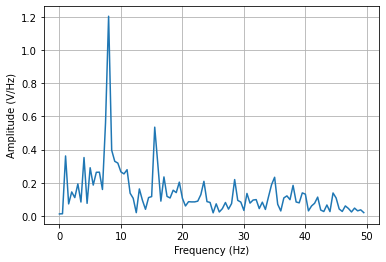

In [6]:
#FFT the whole thing.  
xf = fft(lfp_short) #take the fft 
deltaF = 1/T 
amplitude = 2*np.abs(xf)/nsamp
nf = int(np.floor(nsamp/2)) #number of frequencies you can estimate is 1/2 the number of samples.
                            #I used floor just in case nsamp is odd. 
f_n = np.arange(0,nf)*deltaF
maxf = 50  #highest frequency I want to plot
maxbin = int(maxf/deltaF) #index corresponding to highest frequency to plot.  
amplitude = amplitude/deltaF # amplitude is in V/bin. deltaF is hz/bin  
plt.plot(f_n[0:maxbin],amplitude[0:maxbin])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V/Hz)')
plt.grid(True)
plt.show()

#### Power versus Amplitude 

#### For theoretical reasons (and for some less objective reasons) some results are presented as power rather than amplitde. 

#### Power is the amplitude squared.  Theoretically, it has the same properties as variance, and hence is more useful for theory development.  

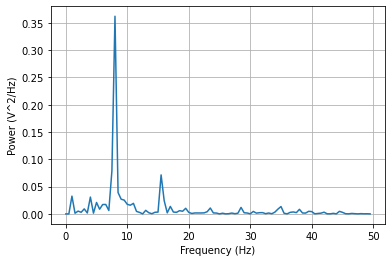

In [7]:
xf = fft(lfp_short) #take the fft 
deltaF = 1/T 
power = 2*(np.abs(xf)/nsamp)**2
nf = int(np.floor(nsamp/2)) #number of frequencies you can estimate is 1/2 the number of samples.
                            #I used floor just in case nsamp is odd. 
f_n = np.arange(0,nf)*deltaF
maxf = 50  #highest frequency I want to plot
maxbin = int(maxf/deltaF) #index corresponding to highest frequency to plot.  
power = power/deltaF # amplitude is in V/bin. deltaF is hz/bin  
plt.plot(f_n[0:maxbin],power[0:maxbin])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (V^2/Hz)')
plt.grid(True)
plt.show()

## Temporal Evolution of EEG spectrum 



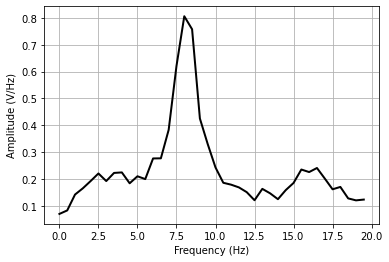

In [10]:
#d averaging them together. 
T = 2# segment length 
nsamp = T*fs # number of samples is the segment length
deltaF = 1/T  #frequency steps
nf = int(np.floor(nsamp/2)) #number of frequencies you can estimate is 1/2 the number of samples.
                            #I used floor just in case nsamp is odd. 
f_n = np.arange(0,nf)*deltaF # the frequencies resolved by the fft 
maxf = 20  #highest frequency I want to plot
maxbin = int(maxf/deltaF) #index to highest frequency I wasnt to plot 
nepochs = 40
amplitude = np.zeros((nepochs,nf)) #I made an empty array to hold the amplitude spectra of each frequency 
for j in range(nepochs):
    lfp_short = lfp[range(j*nsamp,(j+1)*nsamp)]
    xf = fft(lfp_short)
    amplitude[j,:] = 2*np.abs(xf[0:nf])/nsamp #always divide by number of samples. 2 x for negative frequencies 
#    plt.plot(f_n[0:maxbin],amplitude[j,0:maxbin]) #plot the individual epoch spectra (YOU DONT NEED TO DO THIS FOR THE HWK)
amplitude_avg = np.mean(amplitude,axis = 0) #take the average over all epochs
amplitude_avg = amplitude_avg/deltaF
plt.plot(f_n[0:maxbin],amplitude_avg[0:maxbin],'k',linewidth=2) 
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V/Hz)')
plt.grid(True)
plt.show()

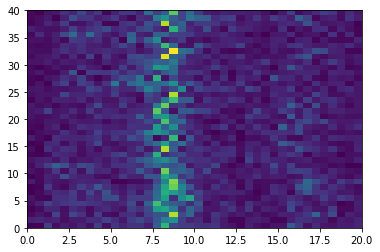

In [11]:
plt.imshow(amplitude[:,0:maxbin],aspect = 'auto',origin='lower',extent = [0,maxf,0,nepochs])
plt.show()

In [12]:
#lets load some P300 ERP data 

data = loadmat('../Exercises/data/2_P3.mat') # ".." means go up a directory
blocktarget = data['blocktarget']
channelnames = data['channelnames']
eeg = data['eeg']
eeg_time = data['eeg_time']
goodtrials = data['goodtrials']
nchannels = data['nchannels']
ntrials = data['ntrials']
response = data['response']
responsetime = data['responsetime']
samplingrate = data['samplingrate']
stimulus = data['stimulus']
target = data['target']
eeg = eeg*10**6


Text(0.5, 1.0, 'PO8')

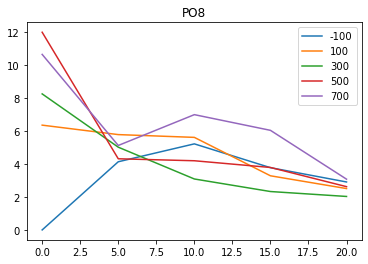

In [15]:
channelno = 25 #25
c_eeg = np.squeeze(eeg[:,channelno,:])
T = 0.2
nsamps = int(T*samplingrate)
deltaF = 1/T  #frequency steps
nf = int(np.floor(nsamp/2)) #number of frequencies you can estimate is 1/2 the number of samples.
                            #I used floor just in case nsamp is odd. 
f_n = np.arange(0,nf)*deltaF # the frequencies resolved by the fft 

for j in range(5):
    tempf = fft(c_eeg[:,j*nsamps:(j+1)*nsamps])
    amplitude = 2*np.abs(tempf)/nsamps
    amplitude_avg = np.mean(amplitude,axis = 0)
    plt.plot(f_n[0:5],amplitude_avg[0:5])

plt.legend(('-100','100','300','500','700'))
plt.title(channelnames[channelno])

Time = 0.2s
delta f = 1/Time =5

f = 0,5,10

## Quantifying the ERP 

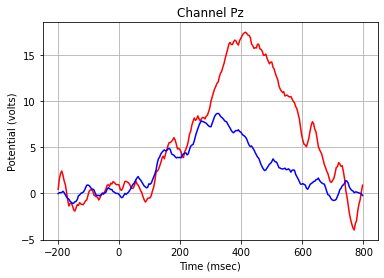

In [16]:
erp_target = np.mean(eeg[(goodtrials == 1)&(blocktarget > 0),:,:],axis =0)
erp_standard = np.mean(eeg[(goodtrials == 1)&(blocktarget == 0),:,:],axis =0)
plt.plot(eeg_time,erp_target[12,:],'r')
plt.plot(eeg_time,erp_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Potential (volts)')
plt.grid()
plt.show()

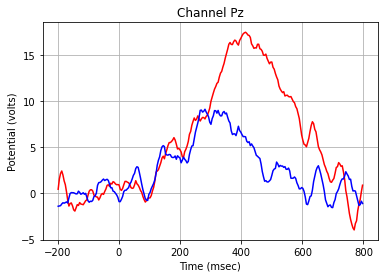

In [17]:
## Lets take care of the random number genearator properly. 
rng = np.random.default_rng(1234)  # The seed can be changed to make a new randomization
###
target_index = np.where(blocktarget > 0)[0]  #notice i had to take the first item from the output to np.where.  This is because where returns it in a list. 
standard_index = np.where(blocktarget == 0)[0] 
rand_standards = rng.permutation(standard_index)
ntargets = len(target_index)
erp_target = np.mean(eeg[target_index,:,:],axis =0)
erp_standard = np.mean(eeg[rand_standards[0:ntargets],:,:],axis =0)
plt.plot(eeg_time,erp_target[12,:],'r')
plt.plot(eeg_time,erp_standard[12,:],'b')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Potential (volts)')
plt.grid()
plt.show()

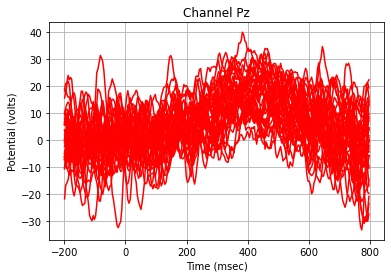

In [18]:
for j in target_index:
    plt.plot(eeg_time,eeg[j,12,:],'r')
plt.title('Channel '+channelnames[12])
plt.xlabel('Time (msec)')
plt.ylabel('Potential (volts)')
plt.grid()
plt.show()